In [25]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


#check version
print("Pandas version: " + pd.__version__)
print("SK Learn version: " + sklearn.__version__)


Pandas version: 2.2.2
SK Learn version: 1.5.0


In [26]:
#load csv file with the correct delimiter 
file_path = 'malware-capture-csv/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv'
df = pd.read_csv(file_path, delimiter='|')

In [27]:
#take a look, displaying the first few rows to verify correct loading 
print("Initial data:") 
print(df.head())

Initial data:
             ts                 uid      id.orig_h  id.orig_p       id.resp_h  \
0  1.545404e+09   CrDn63WjJEmrWGjqf  192.168.1.195      41040  185.244.25.235   
1  1.545404e+09  CY9lJW3gh1Eje4usP6  192.168.1.195      41040  185.244.25.235   
2  1.545404e+09   CcFXLynukEDnUlvgl  192.168.1.195      41040  185.244.25.235   
3  1.545404e+09   CDrkrSobGYxHhYfth  192.168.1.195      41040  185.244.25.235   
4  1.545404e+09  CTWZQf2oJSvq6zmPAc  192.168.1.195      41042  185.244.25.235   

   id.resp_p proto service  duration orig_bytes  ... local_resp missed_bytes  \
0         80   tcp       -  3.139211          0  ...          -            0   
1         80   tcp       -         -          -  ...          -            0   
2         80   tcp       -         -          -  ...          -            0   
3         80   tcp    http  1.477656        149  ...          -         2896   
4         80   tcp       -  3.147116          0  ...          -            0   

       history ori

In [5]:
#check for duplicates 
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicates])


Number of duplicate rows: 0


In [28]:
#check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
ts                    0
uid                   0
id.orig_h             0
id.orig_p             0
id.resp_h             0
id.resp_p             0
proto                 0
service               0
duration              0
orig_bytes            0
resp_bytes            0
conn_state            0
local_orig            0
local_resp            0
missed_bytes          0
history               0
orig_pkts             0
orig_ip_bytes         0
resp_pkts             0
resp_ip_bytes         0
tunnel_parents        0
label                 0
detailed-label    21222
dtype: int64


In [29]:
#display the initial columns
print("Initial columns:")
print(df.columns)

Initial columns:
Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'detailed-label'],
      dtype='object')


In [30]:
#defined the required columns with desired labels
required_columns = {
    'ts': 'Timestamp', 
    'id.orig_h': 'Source_IP', 
    'id.resp_h': 'Destination_IP', 
    'id.orig_p': 'Source_Port', 
    'id.resp_p': 'Destination_Port', 
    'proto': 'Protocol', 
    'duration': 'Duration', 
    'orig_bytes': 'Bytes_Sent', 
    'resp_bytes': 'Bytes_Received', 
    'label': 'Label'
}

#addtional columns if available 
optional_columns = {
    'orig_country': 'Source_Country', 
    'resp_country': 'Destination_Country', 
    'detailed_label': 'Malware_Type', 
    'orig_pkts': 'Packets_Sent', 
    'resp_pkts': 'Packets_Received'
}


In [31]:
#combine required and optional columns
all_columns = {**required_columns, **optional_columns}

#filter the dataframe to keep only the relevant columns
filtered_columns = [col for col in all_columns.keys() if col in df.columns]
df_filtered = df[filtered_columns].copy()

#rename the columns
df_filtered.rename(columns=all_columns, inplace=True)

#display the cleaned DataFrame
print("Cleaned Data:")
print(df_filtered.head())

Cleaned Data:
      Timestamp      Source_IP  Destination_IP  Source_Port  Destination_Port  \
0  1.545404e+09  192.168.1.195  185.244.25.235        41040                80   
1  1.545404e+09  192.168.1.195  185.244.25.235        41040                80   
2  1.545404e+09  192.168.1.195  185.244.25.235        41040                80   
3  1.545404e+09  192.168.1.195  185.244.25.235        41040                80   
4  1.545404e+09  192.168.1.195  185.244.25.235        41042                80   

  Protocol  Duration Bytes_Sent Bytes_Received   Label  Packets_Sent  \
0      tcp  3.139211          0              0  Benign             3   
1      tcp         -          -              -  Benign             1   
2      tcp         -          -              -  Benign             1   
3      tcp  1.477656        149         128252  Benign            94   
4      tcp  3.147116          0              0  Benign             3   

   Packets_Received  
0                 0  
1                 0  


Columns in the dataset:
Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'detailed-label'],
      dtype='object')


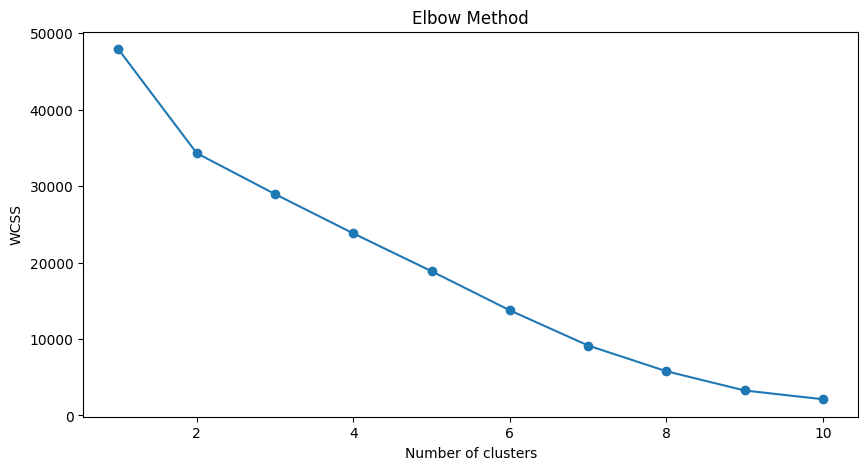

Silhouette Score: 0.6854545601697806


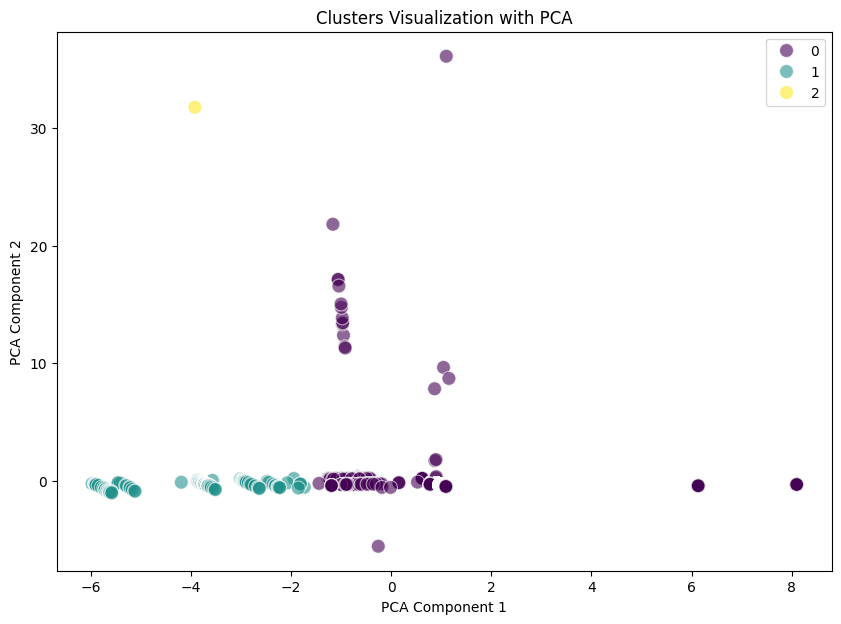

In [32]:
"""

Unsupervised Learning using Clustering (kmeans, sil score, elbow using wcss)

"""
## Inspect columns to understand the structure and available features for analysis
print("Columns in the dataset:")
print(df.columns)

# check if 'proto' exists in the DataFrame
if 'proto' in df.columns:

    # if it exits, encode categorical variables
    # converts categorical text values in protocol column to numerical values using LabelEncoder
    # this is necessary b/c clustering algo like K-Means work with numerical data
    label_encoder = LabelEncoder()
    df['proto'] = label_encoder.fit_transform(df['proto'])

else:
    print("Column 'proto' not found in the dataset. Skipping encoding for 'proto'.")

# convert 'ts' aka timestamps to numerical value
if 'ts' in df.columns:
    # if 'ts' column exits, convert strings to datetime objects 
    df['ts'] = pd.to_datetime(df['ts'], errors='coerce')
    #drops rwos with invalid or missing timestamps
    df.dropna(subset=['ts'], inplace=True)
    # converts the datatime objects to unix time for numerical processing 
    df['ts'] = df['ts'].astype(int) / 10**9
    
else:
    print("Column 'ts' not found in the dataset. Skipping conversion for 'ts'.")

# define features
# we are using the colums that exist in the data set for timestamp, source IP, destination IP, 
# source port, destination port, protocol, duration, bytes sent and bytes receieved 
columns_to_use = ['ts', 'id.orig_h', 'id.resp_h', 'id.orig_p', 'id.resp_p', 'proto', 'duration', 'orig_bytes', 'resp_bytes']
existing_columns = [col for col in columns_to_use if col in df.columns]
# create a new dataframe 'X' with selected features
X = df[existing_columns].copy()

# since IP addresses are categorical, we need to convert them to a suitable format
# if source IP and destination IP address column exits, convert to numerical values for clustering
if 'id.orig_h' in X.columns:
    X.loc[:, 'id.orig_h'] = X['id.orig_h'].apply(lambda x: hash(x) % 10**6)
    # lambda/anaymous function takes argument x which represents an IP address
    # hasing computes a value for IP address into fixed-sized num rep + integer based
    # taking modulo `10**6` limits the range for numerical values (no large numbers)

if 'id.resp_h' in X.columns:
    X.loc[:, 'id.resp_h'] = X['id.resp_h'].apply(lambda x: hash(x) % 10**6)
    # example, consider IP Address: 192.168.1.1 
    # hashing `192.168.1.1` --> hash value `2345678901`
    # modulo `2345678901` --> numerical value for clustering `678901`

# ensure all columns are numeric using pd.to_numeric 
# using errors coerce to convert any non-numeric values to NaN
X = X.apply(pd.to_numeric, errors='coerce')
# drop row with any NaN values, ensure that all data used for clustering is numeric + complete
X.dropna(inplace=True)

# check if X is not empty after preprocessing and before scaling
if not X.empty:

    # normalize/scale the data 
    # scaling to have a mean of 0 and a standard dev of 1, ensures features are
    # contributed equally to clustering process
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # determine the optimal number of clusters using the elbow method
    # Within Cluster Sum of Squares (wcss) is the sum of variance between observations in each cluser
    wcss = []
    # calculates wcss for different numbers of cluser (1 - 10)
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # plot the elbow graph
    # plots the wcss fro differnt number of clusters
    # elbow point in the graph indicates the optimal number of clusters 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # based on the elbow plot, choose the optimal number of clusters
    optimal_clusters = 3  # Example: choose 3 clusters

    # apply K-Means clustering with selcted number of clusers in the scaled data
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    # method fits the model and predicts the cluster labels for each data point
    y_kmeans = kmeans.fit_predict(X_scaled)

    # create a copy of the original DataFrame to store clustering results
    df_clustered = df.loc[X.index].copy()
    # adds a new colum 'Cluster' to the DF, containing the cluster labels for each data point
    df_clustered['Cluster'] = y_kmeans

    # evaluate the clustering using silhouette score
    sil_score = silhouette_score(X_scaled, y_kmeans)
    # silhouette score measures how similar each data point its own cluster compared to other clusters
    # a hgiher silhoutte score will indicate better-defined clusters
    print(f'Silhouette Score: {sil_score}')

    # visualize the clusters using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clustered['Cluster'], palette='viridis', s=100, alpha=0.6)
    plt.title('Clusters Visualization with PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

else:
    print("The DataFrame 'X' is empty after preprocessing. Please check the input data.")




/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_44140/3466050548.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df_clustered, palette='viridis')


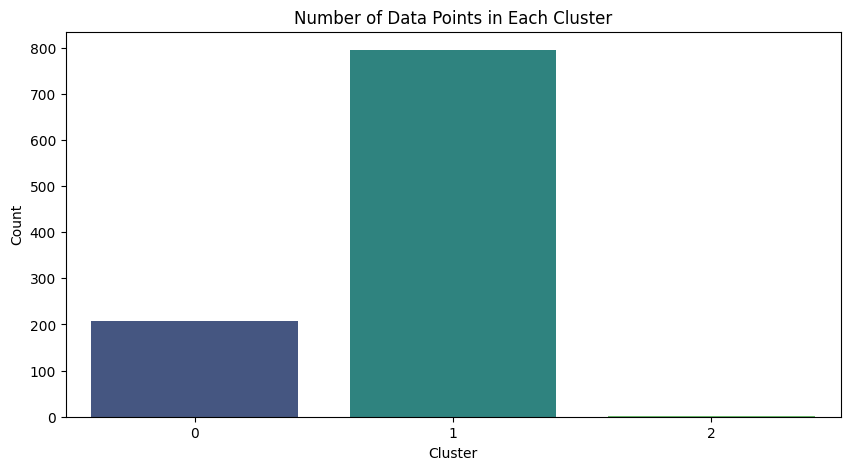

In [36]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Cluster', data=df_clustered, palette='viridis')
plt.title('Number of Data Points in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

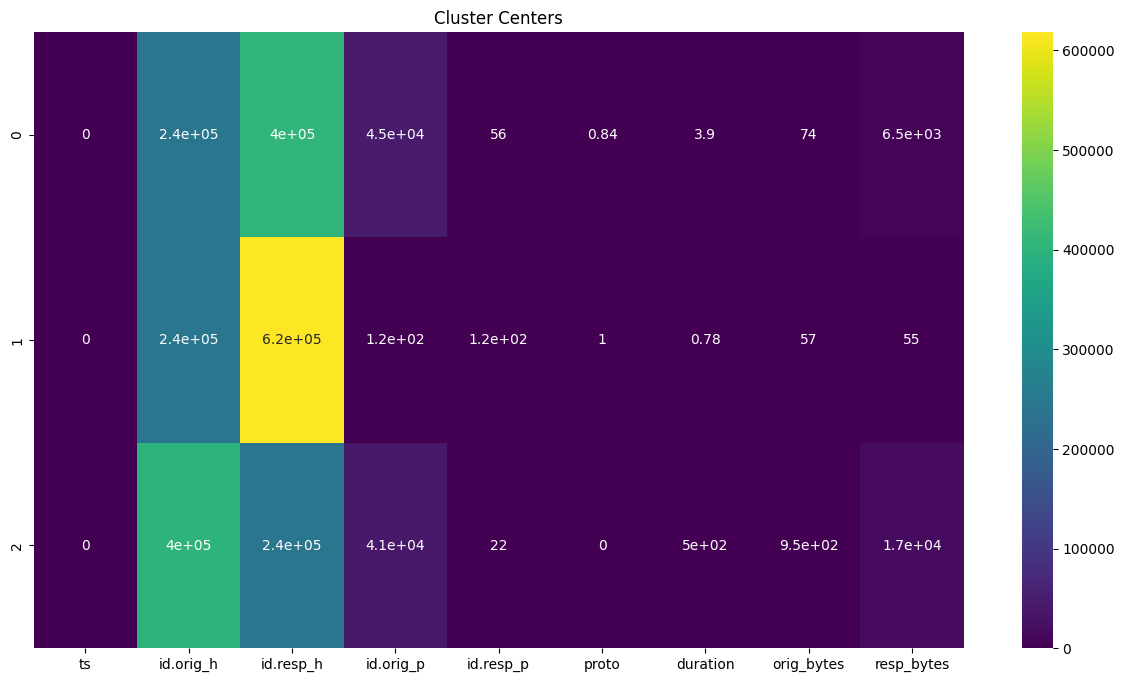

In [37]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=existing_columns)

plt.figure(figsize=(15, 8))
sns.heatmap(cluster_centers_df, annot=True, cmap='viridis')
plt.title('Cluster Centers')
plt.show()

In [33]:
"""
Supervised Learning 

"""
#encode categorical variables
label_encoder = LabelEncoder()
if 'proto' in df.columns:
    df['proto'] = label_encoder.fit_transform(df['proto'])

#convert timestamps to numerical values
if 'ts' in df.columns:
    df['ts'] = pd.to_datetime(df['ts'], errors='coerce')
    df.dropna(subset=['ts'], inplace=True)
    df['ts'] = df['ts'].astype(int) / 10**9

#define features and target
features = ['ts', 'id.orig_h', 'id.resp_h', 'id.orig_p', 'id.resp_p', 'proto', 'duration', 'orig_bytes', 'resp_bytes']
target = 'label'

#select relevant columns
existing_columns = [col for col in features if col in df.columns]
X = df[existing_columns].copy()
y = df[target]

#convert IP addresses to numerical values
if 'id.orig_h' in X.columns:
    X['id.orig_h'] = X['id.orig_h'].apply(lambda x: hash(x) % 10**6)
if 'id.resp_h' in X.columns:
    X['id.resp_h'] = X['id.resp_h'].apply(lambda x: hash(x) % 10**6)

#ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
#drop rows with any NaN values
X.dropna(inplace=True)
# align y with cleaned X
y = y[X.index]

# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#data splitting 
#split the data into training and testing sets, test_size is 0.3 
# we are using 30% of the data for testing, and 70% for training aka 70-30 split
# 1118 instances of training set, 479 instances of testing from the 1597 instances in dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# model training 
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# model evaluations
# Make predictions
y_pred = clf.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)



Accuracy: 0.9993738259236068
Confusion Matrix:
[[ 290    0    0    0]
 [   0 1296    0    0]
 [   1    0    7    0]
 [   0    0    0    3]]
Classification Report:
                                       precision    recall  f1-score   support

                               Benign       1.00      1.00      1.00       290
                      Malicious   C&C       1.00      1.00      1.00      1296
                     Malicious   DDoS       1.00      0.88      0.93         8
Malicious   PartOfAHorizontalPortScan       1.00      1.00      1.00         3

                             accuracy                           1.00      1597
                            macro avg       1.00      0.97      0.98      1597
                         weighted avg       1.00      1.00      1.00      1597



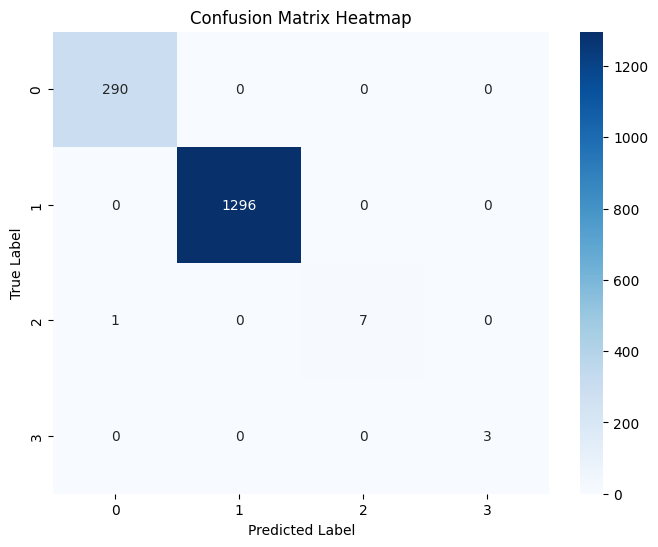

In [23]:
# ensure the label encoder is fitted on the correct classes
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# eompute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# define class names
class_names = label_encoder.classes_

# plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

- there is high accuracy on the model that means that most predictions are correct. the high results in true positvies and mostl zeros in the off-diagonal cells (false positvites and false negatives)
- the might be class imbalance in the data meaning some classes have more instances than others -- leading to fewer opportunies for misclassifications in miniorty classesd 
- how to fix imbalnce? oversampling and undersampling data? synthetic minority over-sample tech, class weights? 

Interpreting the Values
Class "Benign" (Row 1):
- 290 instances were correctly classified as "Benign".
- 0 instances were misclassified as any other class.

Class "Malicious C&C" (Row 2):
- 1296 instances were correctly classified as "Malicious C&C".
- 0 instances were misclassified as any other class.

Class "Malicious DDoS" (Row 3):
- 7 instances were correctly classified as "Malicious DDoS".
- 1 instance was misclassified as "Benign".

Class "Malicious PartOfAHorizontalPortScan" (Row 4):
- 3 instances were correctly classified as "Malicious PartOfAHorizontalPortScan".
- 0 instances were misclassified as any other class.

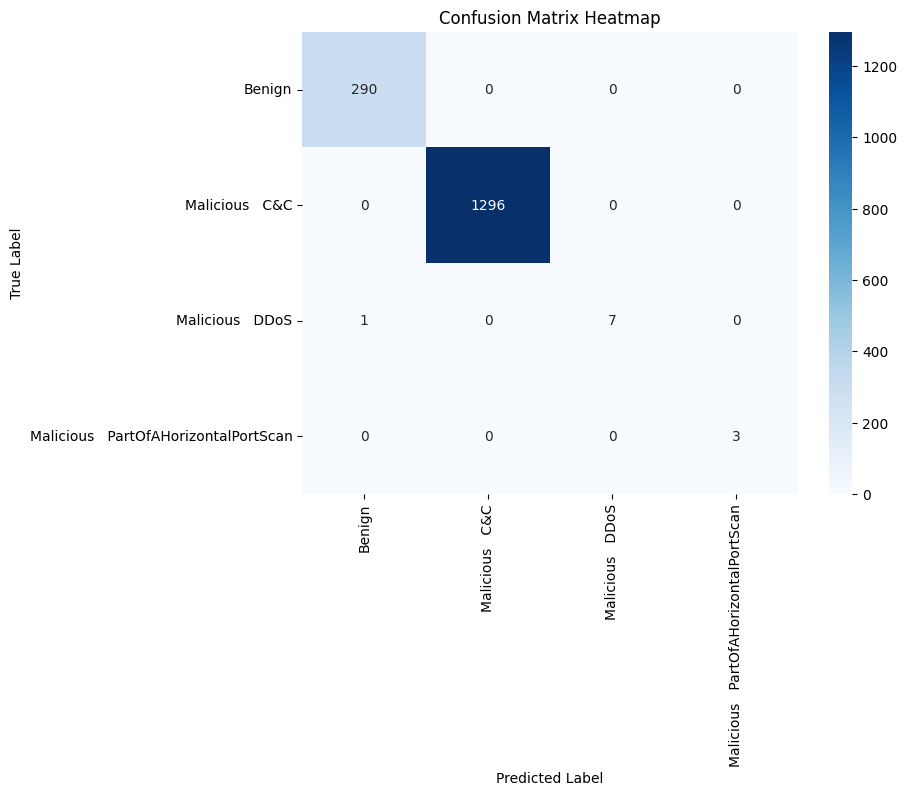

In [24]:
#compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#calculate the number of incorrect predictions
incorrect_predictions = np.sum(conf_matrix) - np.trace(conf_matrix)  # Total - correct predictions

#calculate the total number of predictions
total_predictions = np.sum(conf_matrix)

#calculate percent error
percent_error = (incorrect_predictions / total_predictions) * 100

print(f'Percent Error: {percent_error:.2f}%')

# alternatively, using accuracy score
accuracy = accuracy_score(y_test, y_pred)
percent_error_from_accuracy = (1 - accuracy) * 100

print(f'Percent Error from Accuracy: {percent_error_from_accuracy:.2f}%')

Percent Error: 0.06%
Percent Error from Accuracy: 0.06%


- make class more balance, see how many netwokr detecttion. presetn with dataset. easy method, not to consider a lot of the class. if data is 10% of 1000 entires, count throusand of the enteries of minoriy and 1000 of majority, and then apply random froest for both results. one with OG and one with 